In [ ]:
#| default_exp layers

# Monotonic dense layer

> Monotonic dense layer is a learnable layer built on top of `tf.keras.layers.Dense` layer, but monotonic w.r.t. inputs.

In [ ]:
#| export

from typing import *
from contextlib import contextmanager

import numpy as np
from numpy.typing import ArrayLike, NDArray

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense

2022-12-08 20:45:30.286282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 20:45:30.391947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 20:45:30.391976: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 20:45:30.874962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [ ]:
import pytest

import matplotlib.pyplot as plt

import pandas as pd

from tensorflow.keras import Model
from tensorflow.keras.layers import Input

In [ ]:
def print_header(header: str, length: int=120):
    n = (length-2-len(header)) // 2
    print("*"*length)
    print("*" + " "*(length-2) + "*")
    print("*" + " "*n + header + " "*(length-n-2-len(header)) + "*")
    print("*" + " "*(length-2) + "*")
    print("*"*length)
    print()
print_header("hello")

************************************************************************************************************************
*                                                                                                                      *
*                                                        hello                                                         *
*                                                                                                                      *
************************************************************************************************************************



## Monotonic Dense Unit Class 

### Activation functions

In [ ]:
# |export


def get_saturated_activation(
    convex_activation: Callable[[tf.Tensor], tf.Tensor],
    concave_activation: Callable[[tf.Tensor], tf.Tensor],
    a: float = 1.0,
    c: float = 1.0,
) -> Callable[[tf.Tensor], tf.Tensor]:
    def saturated_activation(
        x: tf.Tensor,
        convex_activation: Callable[[tf.Tensor], tf.Tensor]=convex_activation,
        concave_activation: Callable[[tf.Tensor], tf.Tensor]=concave_activation,
        a: float=a,
        c: float=c,
    ) -> tf.Tensor:
        cc = convex_activation(tf.ones_like(x) * c)
        return a * tf.where(
            x <= c,
            convex_activation(x + c) - cc,
            concave_activation(x - c) + cc,
        )
    
    return saturated_activation

In [ ]:
# | export


def get_activation_functions(
    activation: Optional[Union[str, Callable[[tf.Tensor], tf.Tensor]]] = None
) -> Tuple[
    Optional[Callable[[tf.Tensor], tf.Tensor]],
    Optional[Callable[[tf.Tensor], tf.Tensor]],
    Optional[Callable[[tf.Tensor], tf.Tensor]],
]:
    if activation:
        convex_activation = tf.keras.activations.get(
            activation.lower() if isinstance(activation, str) else activation
        )
        concave_activation = lambda x: -convex_activation(-x)
        saturated_activation = get_saturated_activation(
            convex_activation, concave_activation
        )
        return convex_activation, concave_activation, saturated_activation
    else:
        return None, None, None

2022-12-08 20:45:31.787189: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-08 20:45:31.787209: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 20:45:31.787228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-12-08 20:45:31.787499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


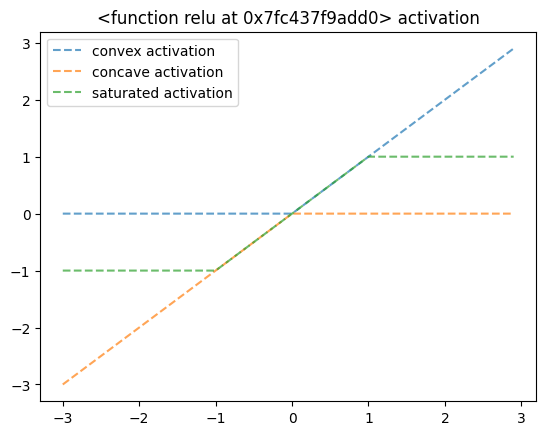

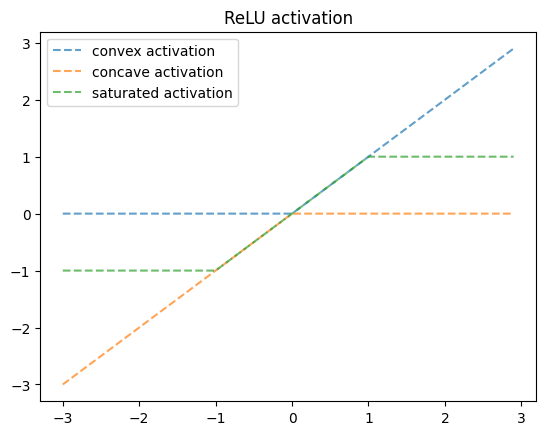

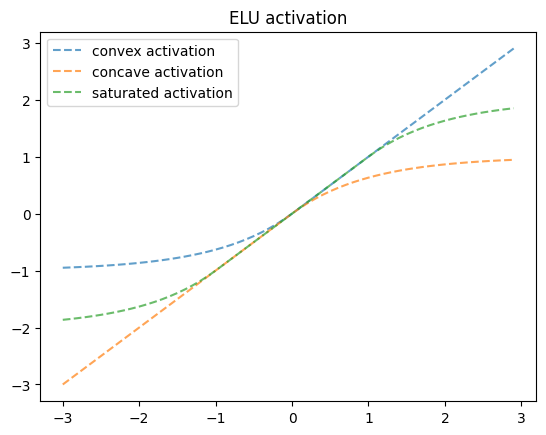

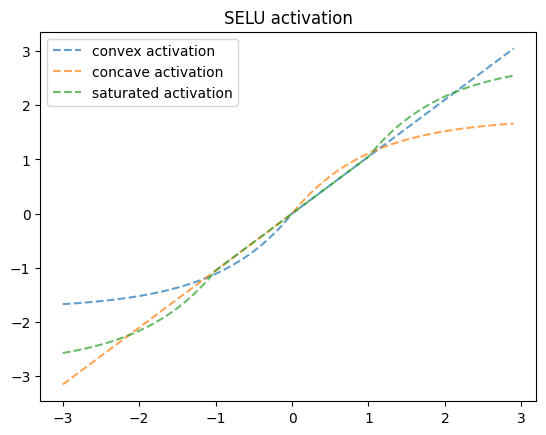

In [ ]:
for activation in [tf.keras.activations.relu, "ReLU", "ELU", "SELU"]:
    (
        convex_activation,
        concave_activation,
        saturated_activation,
    ) = get_activation_functions(activation)

    x = np.arange(-3, 3, 0.1)
    plt.plot(
        x, convex_activation(x), label="convex activation", linestyle="--", alpha=0.7
    )
    plt.plot(
        x, concave_activation(x), label="concave activation", linestyle="--", alpha=0.7
    )
    plt.plot(
        x,
        saturated_activation(x),
        label="saturated activation",
        linestyle="--",
        alpha=0.7,
    )
    plt.legend()
    plt.title(f"{activation} activation")
    plt.show()

In [ ]:
# | export


def apply_activations(
    x: tf.Tensor,
    *,
    units,
    activation: Optional[Union[str, Callable[[tf.Tensor], tf.Tensor]]] = None,
    is_convex: bool = False,
    is_concave: bool = False,
    activation_weights: Tuple[float, float, float] = (1.0, 1.0, 1.0),
) -> tf.Tensor:
    (
        convex_activation,
        concave_activation,
        saturated_activation,
    ) = get_activation_functions(activation)
    
    if convex_activation is None:
        return x
    elif is_convex:
        return convex_activation(x)
    elif is_concave:
        return concave_activation(x)
    else:
        if len(activation_weights) != 3:
            raise ValueError(f"activation_weights={activation_weights}")
        if (np.array(activation_weights) < 0).any():
            raise ValueError(f"activation_weights={activation_weights}")
        normalized_activation_weights = np.array(activation_weights) / sum(activation_weights)
        
        convex_length = round(normalized_activation_weights[0]*units)
        concave_length = round(normalized_activation_weights[1]*units)
        saturated_length = units - convex_length - concave_length
        
        x_convex, x_concave, x_saturated = tf.split(x, (convex_length, concave_length, saturated_length), axis=-1)
       
        y_convex = convex_activation(x_convex)
        y_concave = convex_activation(x_concave)
        y_saturated = saturated_activation(x_saturated)
        
        y = tf.concat([y_convex, y_concave, y_saturated], axis=-1)
        
        return y

In [ ]:
tf.keras.utils.set_random_seed(42)
x = np.random.normal(0, 5, size=(5, 7, 12))

y = apply_activations(
    x,
    activation="relu",
    units=12,
)

assert y.shape == (5, 7, 12)

np.testing.assert_array_almost_equal(y[:, :, :4].numpy(), np.maximum(x[:, :, :4], 0))
np.testing.assert_array_almost_equal(-y[:, :, 4:8].numpy(), -np.maximum(x[:, :, 4:8], 0))
assert (y[:, :, 8:].numpy() != 0).all()
assert (y[:, :, 8:].numpy() >= -1).all()
assert (y[:, :, 8:].numpy() <= 1).all()
assert (y[:, :, 8:].numpy() == -1).any()
assert (y[:, :, 8:].numpy() == 1).any()

### Monotonicity indicator

In [ ]:
#| export

def check_monotonicity_indicator_values(monotonicity_indicator: Union[int, NDArray[np.int_]]):
    if isinstance(monotonicity_indicator, int):
        if monotonicity_indicator not in [-1, 0, 1]:
            raise ValueError(f"monotonicity_indicator must be one of -1, 0, 1, but it is {monotonicity_indicator} instead!")
    else:
        r = (monotonicity_indicator == -1) | (monotonicity_indicator == 0) | (monotonicity_indicator == 1)
        if not r.all():
            raise ValueError(f"Each element of monotonicity_indicator must be one of -1, 0, 1, but it is {monotonicity_indicator}!")

In [ ]:
tf.keras.utils.set_random_seed(42)

with pytest.raises(ValueError) as e:
    check_monotonicity_indicator_values(2)
print(e.value)
    
monotonicity_indicator = np.random.randint(3, size=(4, 5))-1
check_monotonicity_indicator_values(monotonicity_indicator)

monotonicity_indicator = monotonicity_indicator-1
with pytest.raises(ValueError) as e:
    check_monotonicity_indicator_values(monotonicity_indicator)
print(e.value)

monotonicity_indicator must be one of -1, 0, 1, but it is 2 instead!
Each element of monotonicity_indicator must be one of -1, 0, 1, but it is [[ 0 -2  0  0 -2]
 [-2  0 -1  0  0]
 [ 0  0 -2  0 -1]
 [-2 -1 -1 -1 -1]]!


In [ ]:
# |export


def apply_monotonicity_indicator_to_kernel(
    kernel: tf.Variable, monotonicity_indicator: Union[int, NDArray[np.int_]]
) -> tf.Tensor:
    abs_kernel = tf.abs(kernel)
    if isinstance(monotonicity_indicator, int):
        if monotonicity_indicator == 1:
            return abs_kernel
        elif monotonicity_indicator == -1:
            return -abs_kernel
        else:
            return kernel
    else:
        if kernel.shape != monotonicity_indicator.shape:
            raise ValueError("Kernel and monotonicity_indicator must have the same shapes, but we have {kernel.shape} != {monotonicity_indicator.shape=}")
#         monotonicity_indicator = np.expand_dims(monotonicity_indicator, axis=-1)
        kernel = tf.where(
            monotonicity_indicator == 1,
            abs_kernel,
            kernel,
        )
        return tf.where(monotonicity_indicator == -1, -abs_kernel, kernel)

In [ ]:
tf.keras.utils.set_random_seed(42)
layer = Dense(7)
layer.build(
    input_shape=(
        None,
        9,
    )
)

pos_kernel = apply_monotonicity_indicator_to_kernel(layer.kernel, 1)
assert pos_kernel.shape == layer.kernel.shape
assert (pos_kernel >= 0).numpy().all()

neg_kernel = apply_monotonicity_indicator_to_kernel(layer.kernel, -1)
assert neg_kernel.shape == layer.kernel.shape
assert (neg_kernel <= 0).numpy().all()

org_kernel = apply_monotonicity_indicator_to_kernel(layer.kernel, 0)
assert (org_kernel == layer.kernel).numpy().all()

In [ ]:
tf.keras.utils.set_random_seed(42)
layer = Dense(7)
layer.build(
    input_shape=(
        None,
        3,
        5,
        9,
    )
)

monotonicity_indicator = np.random.randint(3, size=(9, 7))-1
check_monotonicity_indicator_values(monotonicity_indicator)

mono_kernel = apply_monotonicity_indicator_to_kernel(
    layer.kernel, monotonicity_indicator
)
assert mono_kernel.shape == layer.kernel.shape

assert ((mono_kernel >= 0).numpy() | (monotonicity_indicator != 1)).all()
assert ((mono_kernel <= 0).numpy() | (monotonicity_indicator != -1)).all()

### Monotonic Dense Layer

In [ ]:
# | export


class MonotonicDense(Dense):
    """Monotonic counterpart of the regular Dense Layer of tf.keras"""

    def __init__(
        self,
        units: int,
        *,
        activation: Optional[Union[str, Callable[[tf.Tensor], tf.Tensor]]] = None,
        monotonicity_indicator: Union[int, NDArray[np.int_]] = 1,
        is_convex: bool = False,
        is_concave: bool = False,
        activation_weights: Tuple[float, float, float] = (1.0, 1.0, 1.0),
        **kwargs,
    ):
        """Constructs a new MonotonicDense instance.

        Params:
            units: Positive integer, dimensionality of the output space.
            activation: Activation function to use, it is assumed to be convex monotonically
                increasing function such as "relu" or "elu"
            monotonicity_indicator: Vector to indicate which of the inputs are monotonically increasing or
                monotonically decreasing or non-monotonic. Has value 1 for monotonically increasing,
                -1 for monotonically decreasing and 0 for non-monotonic.
            is_convex: convex if set to True
            is_concave: concave if set to True
            activation_weights: relative weights for each type of activation, the default is (1.0, 1.0, 1.0).
                Ignored if is_convex or is_concave is set to True
            **kwargs: passed directly to the constructor of `Dense`

        Returns:
            N-D tensor with shape: `(batch_size, ..., units)`.

        Raise:
            ValueError:
                - if both **is_concave** and **is_convex** are set to **True**, or
                - if any component of activation_weights is negative or there is not exactly three components
        """
        check_monotonicity_indicator_values(monotonicity_indicator)

        if is_convex and is_concave:
            raise ValueError(
                "The model cannot be set to be both convex and concave (only linear functions are both)."
            )

        if len(activation_weights) != 3:
            raise ValueError(
                f"There must be exactly three components of activation_weights, but we have this instead: {activation_weights}."
            )

        if (np.array(activation_weights) < 0).any():
            raise ValueError(
                f"Values of activation_weights must be non-negative, but we have this instead: {activation_weights}."
            )

        super(MonotonicDense, self).__init__(units, activation=None, **kwargs)

        self.units = units
        self.org_activation = activation
        self.activation_weights = activation_weights
        self.monotonicity_indicator = monotonicity_indicator
        self.is_convex = is_convex
        self.is_concave = is_concave

    @contextmanager
    def replace_kernel(self):
        """Replaces kernel with non-negative or non-positive values according
        to the **monotonicity_indicator**
        """
        kernel_org = self.kernel
        self.kernel = apply_monotonicity_indicator_to_kernel(
            self.kernel, self.monotonicity_indicator
        )
        try:
            yield
        finally:
            self.kernel = kernel_org

    def build(self, input_shape, *args, **kwargs):
        """Build

        Args:
            input_shape: input tensor
        """
        super(MonotonicDense, self).build(input_shape, *args, **kwargs)
        if not isinstance(self.monotonicity_indicator, int):
            if self.kernel.shape != self.monotonicity_indicator.shape:
                raise ValueError(
                    f"Input shape and monotonicity vector don't have matching shapes: {self.kernel.shape} != {self.monotonicity_indicator.shape}"
                )

    def call(self, inputs):
        """Call

        Args:
            inputs: input tensor
        """
        # calculate W'*x+y after we replace the kernal according to monotonicity vector
        with self.replace_kernel():
            y = super(MonotonicDense, self).call(inputs)

        y = apply_activations(
            y,
            units=self.units,
            activation=self.org_activation,
            is_convex=self.is_convex,
            is_concave=self.is_concave,
            activation_weights=self.activation_weights,
        )

        return y

In [ ]:
tf.keras.utils.set_random_seed(42)

input_shape=(None, 3, 5)
units = 7

layer = MonotonicDense(units, monotonicity_indicator=1, activation="relu")
layer.build(input_shape=input_shape)

In [ ]:
tf.keras.utils.set_random_seed(42)

monotonicity_indicator = np.random.randint(3, size=(11, 13))-1

layer = MonotonicDense(13, monotonicity_indicator=monotonicity_indicator, activation="relu")
layer.build(input_shape=(None, 7, 9, 11))

layer = MonotonicDense(13, monotonicity_indicator=monotonicity_indicator, activation="relu")
with pytest.raises(ValueError) as e:
    layer.build(input_shape=(None, 7, 9, 17))
print(e.value)

Input shape and monotonicity vector don't have matching shapes: (17, 13) != (11, 13)


In [ ]:
tf.keras.utils.set_random_seed(42)

monotonicity_indicator = np.random.randint(3, size=(11, 13))-1

layer = MonotonicDense(13, monotonicity_indicator=monotonicity_indicator, activation="relu")

layer.build(input_shape=(None, 7, 9, 11))

x = np.random.normal(size=(2, 7, 9, 11))
with layer.replace_kernel():
    pass

y = layer(x)
assert y.shape[:-1] == x.shape[:-1]

In [ ]:
tf.keras.utils.set_random_seed(42)

units=17
for x in [np.ones((5, 7)), np.zeros((2, 3))]:
    for activation in [None, "elu", "relu"]:
        for is_convex in [True, False]:
            for is_concave in [True, False]:
                for monotonicity_indicator in [1, np.random.randint(3, size=(x.shape[-1], units))-1]:
                    if is_concave and is_convex:
                        continue
                    if isinstance(monotonicity_indicator, int):
                        print_header(f"{activation=}, {is_convex=}, {is_concave=}, {monotonicity_indicator=}")
                    else:
                        print_header(f"{activation=}, {is_convex=}, {is_concave=}, {monotonicity_indicator.shape=}")

                    layer = MonotonicDense(
                        units=units,
                        monotonicity_indicator=monotonicity_indicator,
                        is_convex=is_convex,
                        is_concave=is_concave,
                        activation=activation,
                    )
                    y = layer(x)
                    print(f"{x.shape=}")
                    print(f"{y.shape=}")
                    print()

************************************************************************************************************************
*                                                                                                                      *
*                     activation=None, is_convex=True, is_concave=False, monotonicity_indicator=1                      *
*                                                                                                                      *
************************************************************************************************************************

x.shape=(5, 7)
y.shape=TensorShape([5, 17])

************************************************************************************************************************
*                                                                                                                      *
*               activation=None, is_convex=True, is_concave=False, monotonicity_indicator.shape=(7, 17)    

x.shape=(2, 3)
y.shape=TensorShape([2, 17])

************************************************************************************************************************
*                                                                                                                      *
*              activation='elu', is_convex=False, is_concave=False, monotonicity_indicator.shape=(3, 17)               *
*                                                                                                                      *
************************************************************************************************************************

x.shape=(2, 3)
y.shape=TensorShape([2, 17])

************************************************************************************************************************
*                                                                                                                      *
*                    activation='relu', is_convex=True, is_con

## Universal approximation

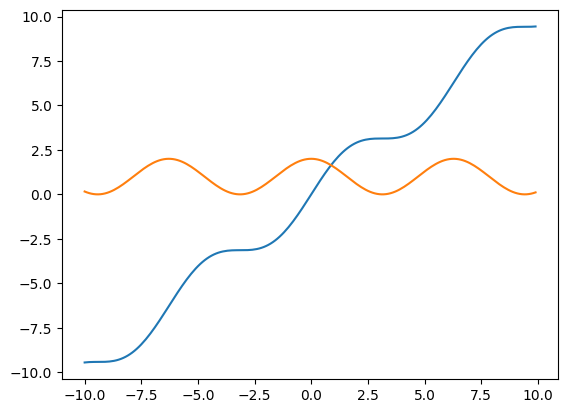

In [ ]:
# this function is problematic for unsaturated activations only

x = np.arange(-10, 10, 0.1)
y = np.sin(x) + x
dy = np.cos(x) + 1
plt.plot(x, y)
plt.plot(x, dy)
# plt.legend()
plt.show()

In [ ]:
def generate_heavyside_dataset(n_points=100_000):
    tf.keras.utils.set_random_seed(42)

    rng = np.random.default_rng(42)
    x_train = rng.normal(size=n_points)
    y_train = (x_train >= 0).astype("float")
    df_train = pd.DataFrame(dict(x=x_train, y=y_train))

    return df_train